In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

model_rf_reload_pkl = pickle.load(open('model_rf.pkl', 'rb'))

/Users/flavioclesio/Documents/github/ml-adversarial/venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/flavioclesio/Documents/github/ml-adversarial/venv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Ataque

Neste exemplo, vamos ver o que um modelo pode revelar e tentar inferir qual é a melhor maneira de explorá-lo.

A única suposição aqui é que sabemos que é um modelo de pontuação de crédito que prevê se alguém vai pagar ou não; mas não temos nenhum conhecimento prévio sobre o modelo.


#### Estimadores
Minha primeira escolha ao ver este arquivo `.pkl` foi tentar verificar se este modelo é um objeto Scikit-Learn.

Já tentei alguns comandos para ver os atributos, mas meu intellisense me deu todos os parâmetros e atributos sem nem mesmo carregar o Scikit-Learn.

Dessa forma, examinarei o número de estimadores desse modelo.

In [2]:
print(f'Number of Estimators: {len(model_rf_reload_pkl.estimators_)}')

Number of Estimators: 5


Com 5 estimadores, posso inferir que este modelo não é tão complexo e minha vida seria bem simples se esses estimadores não tivessem uma grande discrepância entre eles.

Vou verificar agora as características de cada um desses estimadores.

In [3]:
for estimator in model_rf_reload_pkl.estimators_:
    print(f'{estimator}\n')

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=100,
                       random_state=1608637542)

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=100,
                       random_state=1273642419)

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=100,
                       random_state=1935803228)

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=100,
                       random_state=787846414)

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=100,
                       random_state=996406378)



O que estou vendo aqui desses estimadores:
- Como os estimadores estão utilizando o melhor Divisor (`split =”best”`), isso significa que o atacante deve considerar que conhecendo a impureza de cada coluna, o ataque fica mais simples. Isso ocorre porque um elemento com alta impureza não estará nos níveis superiores da árvore; ou seja, essas características de impureza muito alta estarão nos níveis mais baixos.


- Outra informação fornecida aqui é a profundidade da árvore (`max_depth = 3`). Para esse caso, o atacante sabe que não será grande coisa gerar um espaço de busca viável para buscar no ataque; ou o invasor pode inferir que talvez haja algum [_underfitting_](https://chemicalstatistician.wordpress.com/2014/03/19/machine-learning-lesson-of-the-day-overfitting-and-underfitting/) neste modelo e por isso não é necessário um maior nível de precisão no conjunto de combinação de parâmetros.


- Com 100 registros como a quantidade mínima de amostras no nó folha (`min_samples_leaf = 100`), o invasor sabe que cada nó terminal tem pelo menos 100 registros com _algum nível de similaridade_. Em outras palavras, significa que uma vez que o invasor conhece _um nó folha_, ele / ela pode explorá-lo com pequenas modificações naquele espaço de pesquisa.

Agora vamos dar uma olhada em um único estimador.

In [4]:
# Extract single tree (Estimator 4)
estimator = model_rf_reload_pkl.estimators_[4]
print(f'Number of Features: {estimator.n_features_}')

Number of Features: 10


O invasor sabe que esse modelo não é altamente dimensional, o que significa que talvez o espaço de pesquisa de parâmetros não seja muito grande. Mas não sabemos se essas variáveis são contínuas ou discretas.

#### Importâncias Relativas

Vamos alistar as variáveis e ver sua importância relativa.

In [5]:
features_list = [str(x + 0) for x in range(estimator.n_features_)]
features_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Vou criar uma função para verificar todos os recursos dos estimadores para ter uma melhor imagem de quais são as importâncias dos parâmetros.

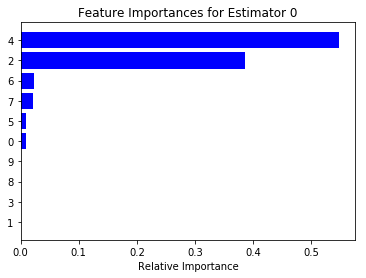

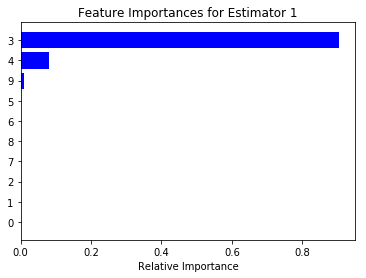

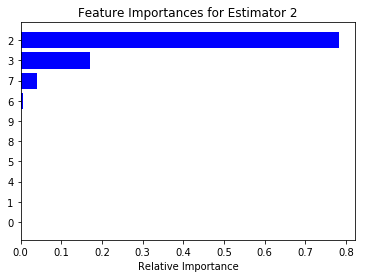

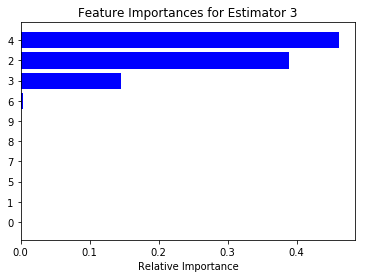

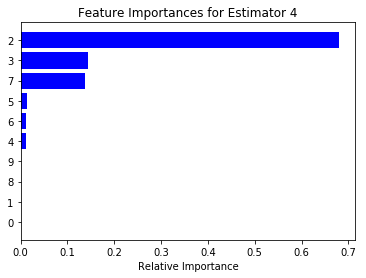

In [6]:
def get_relative_importances_by_estimator(model):
    number_estimators = len(model.estimators_)
    for i in range(0, number_estimators):
        estimator = model.estimators_[i]
        importances = estimator.feature_importances_
        indices = np.argsort(importances)
        plt.figure(1)
        plt.title(f'Feature Importances for Estimator {i}')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), indices)
        plt.xlabel('Relative Importance')
        plt.show()
    
    
get_relative_importances_by_estimator(model=model_rf_reload_pkl)

Ataques na maioria das vezes são sobre `a)` ** espaço de busca ** (no caso de força bruta) ou `b)` ** conhecimento específico ** onde atacar, e esta figura nos dá essas coisas.

Um potencial invasor agora sabe:

- O modelo depende principalmente dos recursos `2, 3` e` 4`;


- Os recursos `0, 1, 9` e` 8` são quase irrelevantes. Isso significa que esses recursos não precisam ser explorados.


Isso torna o espaço de pesquisa para ataques muito mais simples porque o invasor sabe que o modelo possui recursos críticos nos quais se baseia e alguns parâmetros que podem ser descartados.


#### Árvore de decisão em si

Vamos gerar o gráfico para todas as árvores de estimadores e verificar as regras gerais desta árvore.

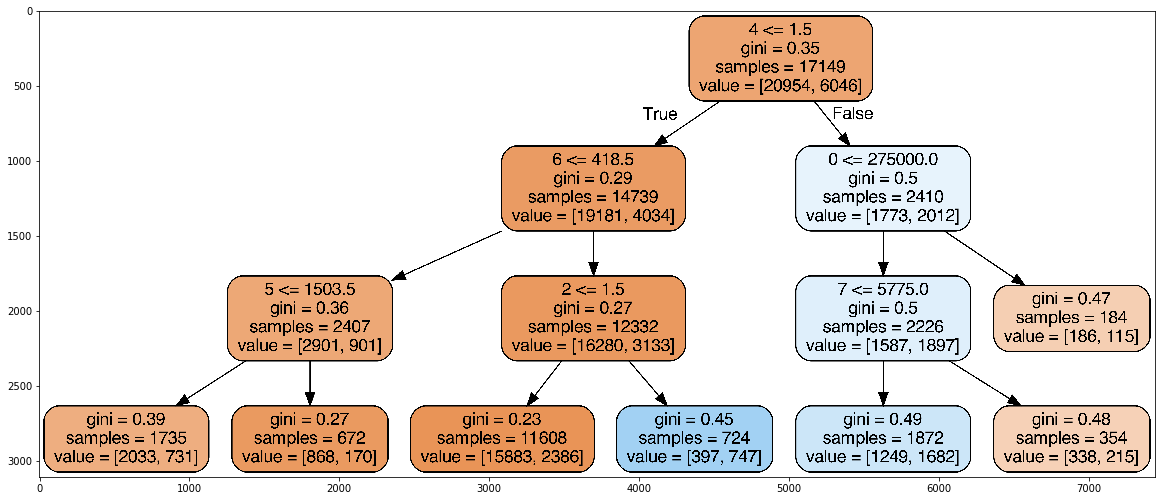

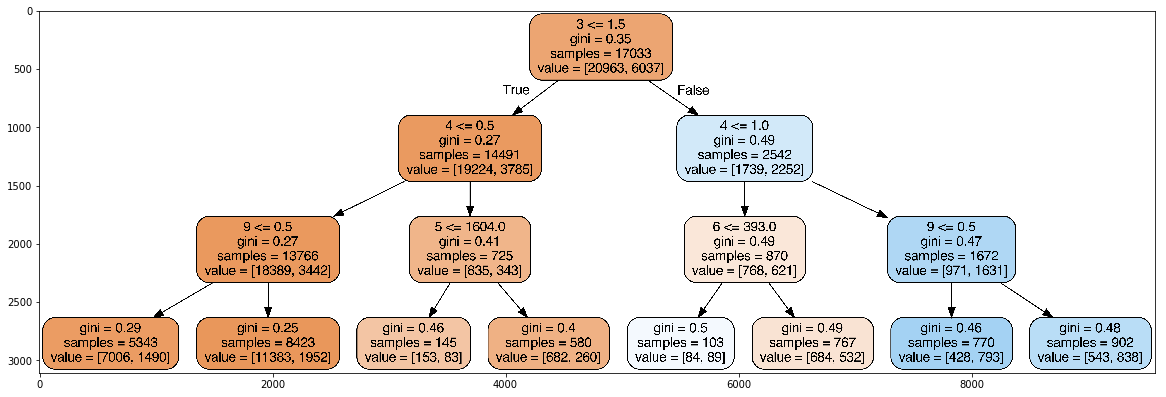

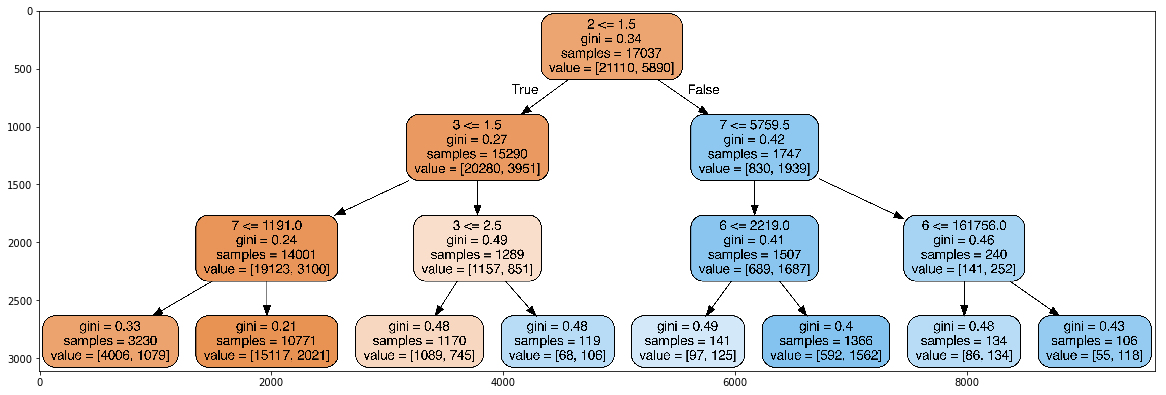

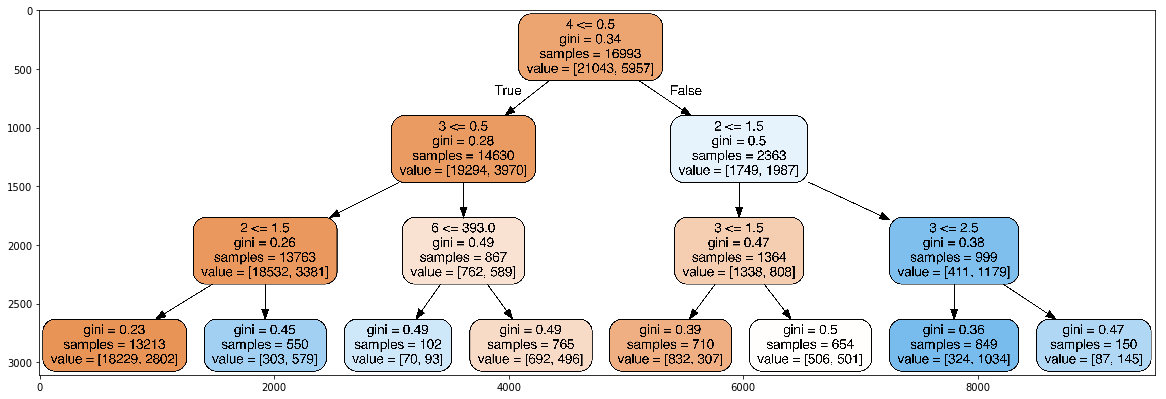

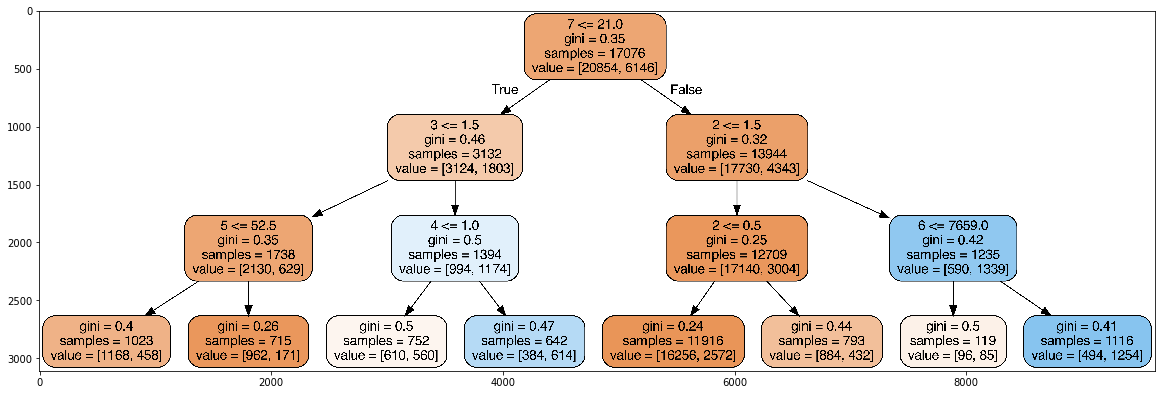

In [7]:
import matplotlib
from sklearn.tree import export_graphviz
from subprocess import call
matplotlib.rc('figure', figsize=(20, 10))

def get_estimators_trees_graphs(model):
    number_estimators = len(model.estimators_)
    for i in range(0, number_estimators):
        estimator = model.estimators_[i]
                
        export_graphviz(estimator, out_file='tree.dot', 
                       feature_names = features_list,
                       rounded = True, proportion = False, 
                       precision = 2, filled = True)

        # Convert to png using system command (requires Graphviz)
        call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

        # Display in jupyter 
        pil_image = Image.open('tree.png')
        np_image_array = np.asarray(pil_image)
        plt.imshow(np_image_array)
        plt.show()
    
    
get_estimators_trees_graphs(model=model_rf_reload_pkl)    

Com os gráficos de árvores do modelo de default de crédito disponíveis, algumas informações estão disponíveis para os atacantes em potencial, como:

- A grande confiança nos campos `2, 3, 4`;  


- Limites claros nas divisões que levam automaticamente ao estado `false` em alguns estimadores (ex:` 7 <= 21` no estimador `4`)

## Contramedidas
- Se for possível, evite que esses artefatos de modelo sejam públicos, não apenas em repositórios, mas também em sistemas de arquivos;


- Se for possível, evite usar modelos que possam ter engenharia reversa como árvores de decisão. O mesmo para modelos de NLP que contêm matrizes de incorporação de palavras disponíveis em atributos e / ou métodos.